<H1>New Spanish Restaurant in NYC</H1>

In this project will try to find an optimal location for a <b>new Spanish restaurant in NYC</B>, we need to find locations (Neighborhood) that that isn’t full of Spanish restaurants. 

On the other hand, We will associate the success of each restaurant to the number of ‘likes’ and their ‘rating we have to find the neighborhood with  the number of rating and their food security

For food security we will use the New York City Restaurant Inspection Data. This dataset provides restaurant inspections, violations, grades and adjudication information.

Using the information obtained through the Foursquare API we will collect the rating and the number of likes. 


In [32]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import pprint
import csv

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import folium # map rendering library

<h2>Load Data</h2>
Firstly let us get the data imported and take a look at a few observations

In [33]:
df = pd.read_csv('restaurants_nyc.csv', error_bad_lines=False)

In [34]:
df.shape

(26854, 23)

In [35]:
df.head()

,index,CAMIS,DBA,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Borough,Neighbourhood,CP
0,382686.0,50095392.0,HOPE TO SEE YOU,133-42,39 AVENUE,11354.0,7188881669,Chinese,01/02/2020,Violations were cited in the following area(s).,...,13.0,A,01/02/2020,10/20/2020,Pre-permit (Operational) / Initial Inspection,40.759099,-73.834139,Queens,North Queens,11354.0
1,123266.0,50100239.0,GD FOOD,14228,38TH AVE,11354.0,3478400866,Chinese,01/08/2020,Violations were cited in the following area(s).,...,12.0,A,01/08/2020,10/20/2020,Pre-permit (Operational) / Initial Inspection,40.761805,-73.826364,Queens,North Queens,11354.0
2,121980.0,50101051.0,KE LAI XIANG/ FLAVORS FISH,136-20,ROOSEVELT AVENUE,11354.0,9293301999,Chinese,01/15/2020,Violations were cited in the following area(s).,...,11.0,A,01/15/2020,10/20/2020,Pre-permit (Operational) / Initial Inspection,40.759778,-73.829235,Queens,North Queens,11354.0
3,160516.0,50098565.0,TARIM UYGHUR CUISINE,136-20,ROOSEVELT AVENUE,11354.0,6193650179,Chinese,01/15/2020,Violations were cited in the following area(s).,...,11.0,A,01/15/2020,10/20/2020,Pre-permit (Operational) / Initial Inspection,40.759778,-73.829235,Queens,North Queens,11354.0
4,129851.0,50101714.0,THE ATTIC,13693,37TH AVE,11354.0,9293290005,Seafood,01/23/2020,Violations were cited in the following area(s).,...,13.0,A,01/23/2020,10/20/2020,Pre-permit (Operational) / Initial Inspection,40.761977,-73.829324,Queens,North Queens,11354.0


<h2>DataSet columns</h2>
Let us find out the column names for what we just pulled in and looked at.

In [36]:
df.columns

Index(['index', 'CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Borough', 'Neighbourhood', 'CP'],
      dtype='object')

<h2>Data Preparation</h2>
<ul>
<li>Remove some unnecessary information</li>
<li>checking missing data in data</li>
<li>Create some new columns (SCORE%,Rating,Likes) </li> 
<li>Convert date columns</li>  
<li>Delete duplicate restaurants</li>   
<li>Filter restaurant by Spanish cuisine</li>       
</ul>

In [37]:
df.drop(columns = ['CP','index'],inplace=True)
df.dropna(subset=['CAMIS','Latitude','Longitude','DBA'], inplace=True)
df['SCORE Per']  = 100-df['SCORE']
df['Rating']  = 0
df['Likes']  = -1
df['RECORD DATE']= pd.to_datetime(df['RECORD DATE'])
df['GRADE DATE']= pd.to_datetime(df['GRADE DATE'])

In [38]:
df.sort_values(by=['GRADE DATE'],inplace=True)
df.dropna(subset=['DBA','SCORE','Latitude','Longitude'])
df.drop_duplicates(subset=['CAMIS'], keep='last', inplace=True)
df.drop(df[df['CUISINE DESCRIPTION'] != 'Spanish'].index, inplace = True)  
df.reset_index(inplace=True)

<h2>Data Visualisation</h2>

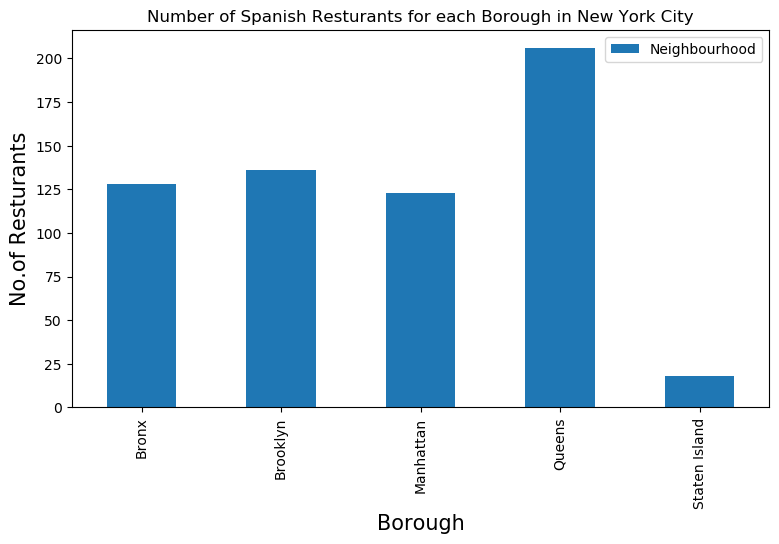

In [204]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Spanish Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Resturants', fontsize=15)
#giving a bar plot
df.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

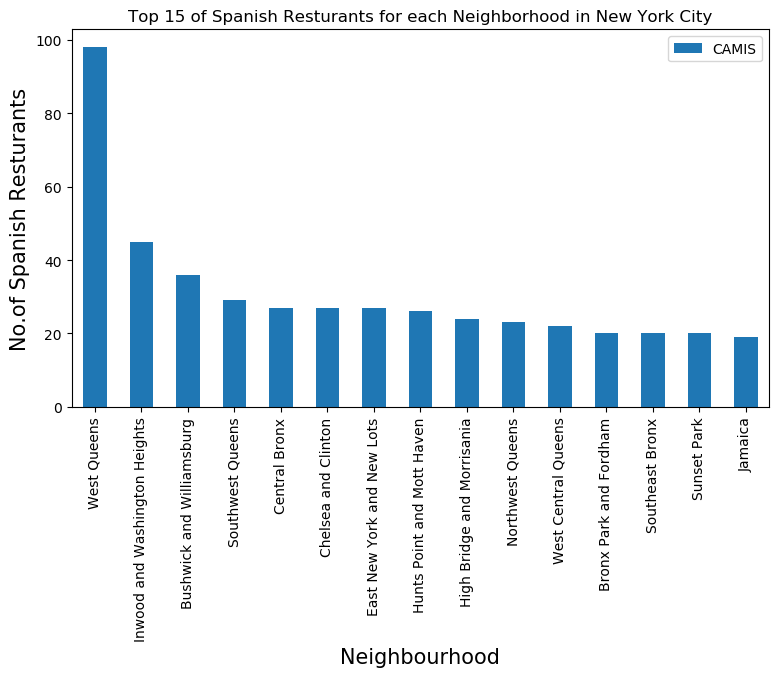

In [201]:
 plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Top 15 of Spanish Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Spanish Resturants', fontsize=15)
#giving a bar plot
df.groupby('Neighbourhood')['CAMIS'].count().nlargest(15).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [42]:
map_all_ny = folium.Map(location=[40.730610, -73.935242], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_all_ny)  
    
map_all_ny

In [205]:
VERSION = '20180605' # Foursquare API version
LIMIT = 1

CLIENT_ID = 'EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKJJZAR' #  Foursquare ID
CLIENT_SECRET = 'QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRMMO35' # Foursquare Secret

In [44]:
def getNearbyVenues(query , latitudes, longitudes, index, radius=500):
    
    
    venues_list=[]

    print("Fetching venues for : ",query)            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitudes, 
        longitudes, 
        radius, 
        LIMIT,
        query.replace(' ', '+'))
    print(url)
            
    # make the GET request
  
    results = requests.get(url).json()["response"]["venues"]
    if len(results):
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            results[0]['id'],
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        print(url)
        results = requests.get(url).json()["response"]["venue"]      
        if len(results):   
            if 'rating' in results.keys():
                df.loc[index, "Rating"] = results['rating']
            if 'likes' in results.keys():
                df.loc[index, "Likes"] = results['likes']['count']
            else:
                 df.loc[index, "Likes"] = 0
        else:
            df.loc[index, "Likes"] = 0
            df.loc[index, "Rating"] = 0
            
        
    #print(json.dumps(results, indent=2))   
    # return only relevant information for each nearby venue
    
    return(True)

<h1>Collect Rating and Links from Foursqaure API</h1> 

In [45]:
for i in range(len(df)) :
    if df.loc[i, "Likes"] == -1:
        if df.loc[i, "Latitude"] > 0:
            getNearbyVenues(query=df.loc[i, "DBA"],latitudes=df.loc[i, "Latitude"],longitudes=df.loc[i, "Longitude"],index=i)

Fetching venues for :  SALINAS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.743708079491,-74.00333456270799&radius=500&limit=1&query=SALINAS
https://api.foursquare.com/v2/venues/4de00d3c1850ff3700a450b0?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  LA ABUNDANCIA RESTAURANT & BAKERY
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.747544920143,-73.88460804269499&radius=500&limit=1&query=LA+ABUNDANCIA+RESTAURANT+&+BAKERY
Fetching venues for :  SALUD Y ESPERANZA
https://api.foursquare.com/v2/venues/search?categoryId=4bf5

https://api.foursquare.com/v2/venues/4ee799918b81381c2a21569e?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  MARY'S COFFEE SHOP
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.692609870994,-73.940611831033&radius=500&limit=1&query=MARY'S+COFFEE+SHOP
Fetching venues for :  EL CAMPEON DE LOS POLLOS 2
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.686043807579004,-73.83974812336601&radius=500&limit=1&query=EL+CAMPEON+DE+LOS+POLLOS+2
Fetching venues for :  CHICKENFEST AZTECA
https://api.foursquare.com/v2/venues/search?categ

Fetching venues for :  DOS31
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.71045346794,-73.959056637948&radius=500&limit=1&query=DOS31
Fetching venues for :  CAFE SALAMANCA RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.755283014218,-73.887991094431&radius=500&limit=1&query=CAFE+SALAMANCA+RESTAURANT
https://api.foursquare.com/v2/venues/4bdc8c5cafe8c9b628f14f85?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  STREET TACO
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all

https://api.foursquare.com/v2/venues/4e187f52b0fb8567c66d001b?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  LLAMA PARTY
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.766812226924,-73.982808747226&radius=500&limit=1&query=LLAMA+PARTY
Fetching venues for :  LULO RESTAURANT BRONX
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.856808872772,-73.900305656102&radius=500&limit=1&query=LULO+RESTAURANT+BRONX
Fetching venues for :  LOS MARINILLOS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&in

Fetching venues for :  SABOR BORINQUENO # 2
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.801599594688,-73.936822768592&radius=500&limit=1&query=SABOR+BORINQUENO+#+2
Fetching venues for :  El Rancho Vegano
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.797359327396,-73.937498594691&radius=500&limit=1&query=El+Rancho+Vegano
Fetching venues for :  LA FONDA REST CORP
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.737474225397,-73.895927366513&radius

https://api.foursquare.com/v2/venues/4c3ce41815cb1b8d4d3c7bdc?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  CALATO BROOKLYN KITCHEN
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.642016335071,-74.012780951086&radius=500&limit=1&query=CALATO+BROOKLYN+KITCHEN
Fetching venues for :  PUERTO RICO RESTAURANT & PIZZA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.641596243797004,-74.013977162664&radius=500&limit=1&query=PUERTO+RICO+RESTAURANT+&+PIZZA
Fetching venues for :  EL DIAMANTE INTERNACIONAL CAFE
https://api.foursquar

https://api.foursquare.com/v2/venues/49baad11f964a52093531fe3?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  MILANES SPANISH RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.744932117673,-73.99367720604&radius=500&limit=1&query=MILANES+SPANISH+RESTAURANT
https://api.foursquare.com/v2/venues/4b50dbe2f964a520a63527e3?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  NUCHAS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20

Fetching venues for :  NELLY'S CAFE
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.759972360742005,-73.941439528988&radius=500&limit=1&query=NELLY'S+CAFE
Fetching venues for :  VAN DAM DELI
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.735876279729,-73.93662191131601&radius=500&limit=1&query=VAN+DAM+DELI
Fetching venues for :  CAFE OLE RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.75390447008,-73.924029578577&radius=500&limit=1&query=

Fetching venues for :  EL CAPRI RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.846859656274,-73.935507329488&radius=500&limit=1&query=EL+CAPRI+RESTAURANT
https://api.foursquare.com/v2/venues/4e4cd041bd413c4cc66c5d87?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  LA CASA DEL POLLO AND PIZZA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.849261970953,-73.936715876899&radius=500&limit=1&query=LA+CASA+DEL+POLLO+AND+PIZZA
https://api.foursquare.com/v2/venues/58fe77e60a464d5a317824bc?&client_id=EJXHEWCNSZSZKZKCB4X

Fetching venues for :  LA PICARDIA DE BROADWAY
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.830677235803,-73.94735751793199&radius=500&limit=1&query=LA+PICARDIA+DE+BROADWAY
Fetching venues for :  SOLACE BAR & GRILL
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.824983717870005,-73.95148838205401&radius=500&limit=1&query=SOLACE+BAR+&+GRILL
Fetching venues for :  BRISA DOMINICANA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.826751862978,-73.9465

Fetching venues for :  RICO POLLO #1
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.699987763378,-73.90739695243&radius=500&limit=1&query=RICO+POLLO+#1
https://api.foursquare.com/v2/venues/4b8b3fa1f964a520659932e3?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  EL PIN POLLO RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.708926053428,-73.912564061387&radius=500&limit=1&query=EL+PIN+POLLO+RESTAURANT
Fetching venues for :  LIBERTADOR
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735

https://api.foursquare.com/v2/venues/4a655d46f964a52086c71fe3?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  PICA PICA CON SABOR RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.70719641702,-73.954409416175&radius=500&limit=1&query=PICA+PICA+CON+SABOR+RESTAURANT
Fetching venues for :  CERVECCERIA HAVEMEYER
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.711740174946,-73.957436257964&radius=500&limit=1&query=CERVECCERIA+HAVEMEYER
Fetching venues for :  El BORN
https://api.foursquare.com/v2/venues/search?category

Fetching venues for :  CARIDAD RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.829139973109,-73.87577555073399&radius=500&limit=1&query=CARIDAD+RESTAURANT
https://api.foursquare.com/v2/venues/54de3178498e358e58c0de5d?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  GUATELINDA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.831447638303,-73.867803203855&radius=500&limit=1&query=GUATELINDA
Fetching venues for :  PUPUSERIA SALVADORENA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&i

Fetching venues for :  LA ESTRELLA TROPICAL
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.871391343687,-73.865065877195&radius=500&limit=1&query=LA+ESTRELLA+TROPICAL
Fetching venues for :  CARIDAD & LOUIE'S RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.866017481114994,-73.837714700991&radius=500&limit=1&query=CARIDAD+&+LOUIE'S+RESTAURANT
https://api.foursquare.com/v2/venues/4be2ecf6b02ec9b6a5064ec0?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  EL VALLE RESTAURANTE
https://api.foursquare.com/v2/venues/sear

Fetching venues for :  LA FLACA COFFEE SHOP RESTAURANT AND BAR
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.74750197193,-73.863026033107&radius=500&limit=1&query=LA+FLACA+COFFEE+SHOP+RESTAURANT+AND+BAR
Fetching venues for :  LA MORENITA ECUATORIANA RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.757342598018,-73.868268486711&radius=500&limit=1&query=LA+MORENITA+ECUATORIANA+RESTAURANT
Fetching venues for :  MAMA CATALINA RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LA

Fetching venues for :  EL NUEVO POLANCO RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.757465679027,-73.860922733446&radius=500&limit=1&query=EL+NUEVO+POLANCO+RESTAURANT
Fetching venues for :  CARIDAD RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.75733715822,-73.868311812464&radius=500&limit=1&query=CARIDAD+RESTAURANT
https://api.foursquare.com/v2/venues/4daa0d7e0cb6a89c6265a89f?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  CHARO RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=

Fetching venues for :  LA GRAN URUGUAYA BAKERY & RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.750044808722,-73.881337386116&radius=500&limit=1&query=LA+GRAN+URUGUAYA+BAKERY+&+RESTAURANT
Fetching venues for :  EL TRIGAL BAKERY & RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.750566741526,-73.876539811989&radius=500&limit=1&query=EL+TRIGAL+BAKERY+&+RESTAURANT
Fetching venues for :  EL GRAN COFFEE SHOP
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQ

Fetching venues for :  EMPANADAS MONUMENTAL
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.833860033534,-73.945009670295&radius=500&limit=1&query=EMPANADAS+MONUMENTAL
Fetching venues for :  JOHN'S FRIED CHICKEN
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.836315712227,-73.943236832723&radius=500&limit=1&query=JOHN'S+FRIED+CHICKEN
Fetching venues for :  EMPANADAS MONUMENTAL
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.844473596312,-73.938910729

Fetching venues for :  LES CREPES & TAQUERIA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.715417379228,-73.989831031395&radius=500&limit=1&query=LES+CREPES+&+TAQUERIA
Fetching venues for :  BALVANERA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.720530409068,-73.985443437944&radius=500&limit=1&query=BALVANERA
Fetching venues for :  EL CASTILLO DE MANHATTAN RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.712686306369,-73.989521234924&r

Fetching venues for :  EL PUNTO COLUMBIANO RESTAURANTE BAKERY
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.782953489939,-73.84585846956&radius=500&limit=1&query=EL+PUNTO+COLUMBIANO+RESTAURANTE+BAKERY
Fetching venues for :  EL VICENTINO RESTAURANT 2
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.780285812201,-73.846027156129&radius=500&limit=1&query=EL+VICENTINO+RESTAURANT+2
Fetching venues for :  MR DRE KITCHEN BAR
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&

Fetching venues for :  NEW LOTS RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.662420046446,-73.891780885036&radius=500&limit=1&query=NEW+LOTS+RESTAURANT
Fetching venues for :  HE CHEROKEE DELI RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.685012075132,-73.914196446132&radius=500&limit=1&query=HE+CHEROKEE+DELI+RESTAURANT
Fetching venues for :  STANLEY COFFEE SHOP
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.65937383071,-73

Fetching venues for :  JIREH RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.604852558329,-74.005142655605&radius=500&limit=1&query=JIREH+RESTAURANT
https://api.foursquare.com/v2/venues/4e6cea4a483b1f5ebe47c982?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  LA FOGATA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.605728260524,-74.000147655221&radius=500&limit=1&query=LA+FOGATA
https://api.foursquare.com/v2/venues/57730a1b498e63c34c482b27?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secre

Fetching venues for :  LA GUALACENA BAR & RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.702135144446004,-73.91577203594&radius=500&limit=1&query=LA+GUALACENA+BAR+&+RESTAURANT
https://api.foursquare.com/v2/venues/4e4d71bebd413c4cc6711d53?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  NOWHERE BAR LOUNGE RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.701689280709,-73.921813576502&radius=500&limit=1&query=NOWHERE+BAR+LOUNGE+RESTAURANT
Fetching venues for :  EL ENCEBOLLADO DE ROSSY
https://api.foursqu

Fetching venues for :  MISTURA PERUANA RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.692380993886,-73.86034501873701&radius=500&limit=1&query=MISTURA+PERUANA+RESTAURANT
Fetching venues for :  RESTAURANT ANTOJITOS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.692854090737,-73.854523817673&radius=500&limit=1&query=RESTAURANT+ANTOJITOS
https://api.foursquare.com/v2/venues/4cc0ce291da0a1cd4e3b96c6?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  BICHEIROS BAR
https://api.foursquare.com/v2/venues/search?categoryI

Fetching venues for :  EL GRAN MAR DE PLATA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.682132417809,-73.877517894664&radius=500&limit=1&query=EL+GRAN+MAR+DE+PLATA
Fetching venues for :  TORIBIO RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.681954695421,-73.878163603774&radius=500&limit=1&query=TORIBIO+RESTAURANT
https://api.foursquare.com/v2/venues/4e70e681a8098087a04fbf9c?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  DON CHIMI RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d

Fetching venues for :  RESTAURANTE & PANADERIA GUATELINDA
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.707275435949995,-73.789319839659&radius=500&limit=1&query=RESTAURANTE+&+PANADERIA+GUATELINDA
Fetching venues for :  PUNTO CIBAENO RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.707473192985,-73.797001855962&radius=500&limit=1&query=PUNTO+CIBAENO+RESTAURANT
Fetching venues for :  JM COFFEE SHOP & BAKERY
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v

Fetching venues for :  TROPICAL RESTAURANT # 3
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.713044534008006,-73.900705478828&radius=500&limit=1&query=TROPICAL+RESTAURANT+#+3
Fetching venues for :  EL POLLO SABROSON
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.724627620641996,-73.897762228849&radius=500&limit=1&query=EL+POLLO+SABROSON
Fetching venues for :  RUDY'S DELI RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.729980490261,-73.9

Fetching venues for :  QUE SABROSURA RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.858331466952,-73.902653166966&radius=500&limit=1&query=QUE+SABROSURA+RESTAURANT
https://api.foursquare.com/v2/venues/4bf5cfe8004ed13afb6941a0?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  FANTASY BAR AND RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.85157625774,-73.90883340375301&radius=500&limit=1&query=FANTASY+BAR+AND+RESTAURANT
Fetching venues for :  EL VIEJO JOBO SEAFOOD RESTAURANT
https://api.foursquare.com/

Fetching venues for :  PUERTA DEL SOL RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.620259139997,-73.99822054586&radius=500&limit=1&query=PUERTA+DEL+SOL+RESTAURANT
Fetching venues for :  RUBY'S RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.842541970121005,-73.867882270222&radius=500&limit=1&query=RUBY'S+RESTAURANT
https://api.foursquare.com/v2/venues/58836adb4bafb72b41f15e94?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  SOLIMAR GRILL
https://api.foursquare.com/v2/venues/search?categoryId=4bf58d

Fetching venues for :  TACOS Y MAS
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.603093694177,-73.750756717031&radius=500&limit=1&query=TACOS+Y+MAS
https://api.foursquare.com/v2/venues/4e3d97f762e19d610970bdf7?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605
Fetching venues for :  RANDALL RESTAURANT
https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d150941735&intent=all&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client_secret=QQ0R4IRL0B4EDRUQGNOC3LAGHMBHZ5YJDC0TN3BPYNQRRO35&v=20180605&ll=40.81245795914,-73.88417715544&radius=500&limit=1&query=RANDALL+RESTAURANT
https://api.foursquare.com/v2/venues/4c9ca8fc54c8a1cd9e057c4b?&client_id=EJXHEWCNSZSZKZKCB4XVVFM53VTLPHIPM0GKJGWNYOIEKZAR&client

<h1>Update Rating</h1>
We will remove  restaurants without a rating 

In [49]:
df['Rating'].value_counts()

0.0    541
7.8      7
7.7      6
7.4      5
6.3      3
8.0      3
6.5      3
8.1      3
6.6      3
8.4      3
7.1      3
7.3      2
8.7      2
6.4      2
8.8      2
8.6      2
8.3      2
6.9      2
7.2      2
7.6      2
7.5      2
6.8      2
7.0      1
9.0      1
5.9      1
8.5      1
6.2      1
9.1      1
9.2      1
8.2      1
7.9      1
Name: Rating, dtype: int64

In [57]:
df_rating = df[df['Rating'] > 0 ]

In [ ]:
df.loc[df['Rating'] == 0 ,['Rating']] = df[df['Rating'] > 0 ]['Rating'].sum()/df[df['Rating'] > 0 ]['Rating'].count()

In [60]:
df_rating[df_rating['Likes'] > 0 ].shape

(70, 25)

<h1>K: Clustering the neighbourhoods with k-means.</h1>

In [174]:
kclusters = 10

ny_grouped_clustering = pd.DataFrame(df_rating[['CAMIS','Longitude','Latitude','SCORE Per','Rating','Likes']])
ny_grouped_clustering.dropna(subset=['CAMIS','Longitude','Latitude','SCORE Per','Rating','Likes'],inplace=True)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering[['SCORE Per','Rating','Likes']])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([9, 9, 8, 3, 3, 3, 0, 3, 1, 0], dtype=int32)

In [175]:
ny_grouped_clustering

,CAMIS,Longitude,Latitude,SCORE Per,Rating,Likes
0,41588320.0,-74.003335,40.743708,97.0,8.1,253
3,50006114.0,-73.938428,40.846296,87.0,8.7,233
12,41233476.0,-73.993046,40.739794,89.0,9.2,905
13,50085920.0,-73.812602,40.704928,91.0,7.5,28
16,50088027.0,-73.899233,40.867823,95.0,7.2,3
...,...,...,...,...,...,...
565,40383609.0,-74.158368,40.626290,80.0,7.7,24
577,41118287.0,-73.842624,40.680684,77.0,6.4,6
579,40601738.0,-74.149190,40.551526,55.0,6.5,4
602,41594371.0,-73.884177,40.812458,75.0,6.6,5


In [176]:
ny_grouped_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
df_merged = pd.merge(df_rating, ny_grouped_clustering, how='right', right_on='CAMIS', left_on='CAMIS')

In [177]:
df_merged.drop(columns = ['SCORE Per_y','Rating_y'],inplace=True)


In [178]:
df_merged['Cluster Labels'].value_counts()

3    22
6    20
0     7
7     4
9     3
4     3
2     3
8     1
5     1
1     1
Name: Cluster Labels, dtype: int64

<h2>Visualize the resulting clusters</h2>

In [179]:
# create map
map_clusters = folium.Map(location=[40.730610, -73.935242], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude_x'], df_merged['Longitude_x'], df_merged['Neighbourhood'], df_merged['Cluster Labels']  ):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h1>Conclusion</h1>

In [182]:
for x in range(0, kclusters):
    print("Cluster Labels = ", x)
    print(df_merged[df_merged['Cluster Labels'] == x][['SCORE Per_x','Rating_x','Likes_x']].mean())
    print(df_merged[df_merged['Cluster Labels'] == x][['Likes_x']].count())
    print("\n")
    

Cluster Labels =  0
SCORE Per_x    78.142857
Rating_x        7.614286
Likes_x        80.714286
dtype: float64
Likes_x    7
dtype: int64


Cluster Labels =  1
SCORE Per_x     88.0
Rating_x         9.0
Likes_x        835.0
dtype: float64
Likes_x    1
dtype: int64


Cluster Labels =  2
SCORE Per_x     78.333333
Rating_x         8.666667
Likes_x        379.000000
dtype: float64
Likes_x    3
dtype: int64


Cluster Labels =  3
SCORE Per_x    84.000000
Rating_x        7.186364
Likes_x        13.545455
dtype: float64
Likes_x    22
dtype: int64


Cluster Labels =  4
SCORE Per_x     70.333333
Rating_x         7.866667
Likes_x        202.333333
dtype: float64
Likes_x    3
dtype: int64


Cluster Labels =  5
SCORE Per_x     91.0
Rating_x         9.1
Likes_x        493.0
dtype: float64
Likes_x    1
dtype: int64


Cluster Labels =  6
SCORE Per_x    70.450
Rating_x        7.355
Likes_x        24.450
dtype: float64
Likes_x    20
dtype: int64


Cluster Labels =  7
SCORE Per_x     74.75
Rating_x         

In [183]:
df_merged['Cluster Labels'].value_counts()

3    22
6    20
0     7
7     4
9     3
4     3
2     3
8     1
5     1
1     1
Name: Cluster Labels, dtype: int64

In [192]:
ny_restaurant = df_merged[(df_merged['Cluster Labels'] == 1) | (df_merged['Cluster Labels'] == 2) | (df_merged['Cluster Labels'] == 4) | (df_merged['Cluster Labels'] == 5) | (df_merged['Cluster Labels'] == 9) | (df_merged['Cluster Labels'] == 9)]

In [198]:
ny_restaurant['Neighbourhood'].value_counts()

Chelsea and Clinton              5
Greenwich Village and Soho       2
Lower East Side                  2
Northwest Brooklyn               1
Inwood and Washington Heights    1
Name: Neighbourhood, dtype: int64

In [199]:
df['Neighbourhood'].value_counts()

West Queens                      98
Inwood and Washington Heights    45
Bushwick and Williamsburg        36
Southwest Queens                 29
East New York and New Lots       27
Central Bronx                    27
Chelsea and Clinton              27
Hunts Point and Mott Haven       26
High Bridge and Morrisania       24
Northwest Queens                 23
West Central Queens              22
Southeast Bronx                  20
Sunset Park                      20
Bronx Park and Fordham           20
Northwest Brooklyn               19
Jamaica                          19
Lower East Side                  14
Southwest Brooklyn                9
Greenwich Village and Soho        9
Central Brooklyn                  9
East Harlem                       8
Greenpoint                        8
Stapleton and St. George          8
Gramercy Park and Murray Hill     8
Kingsbridge and Riverdale         7
Port Richmond                     7
Borough Park                      6
North Queens                

We recommend our business partner to open the new restaurant in a trendy Neighborhood with few Spanish restaurants open.

With that, we have concluded that the best recommendation will be neighborhood Chelsea and Clinton with a higher Trendy Recommendation, lower competition and easy replication for business expansion. 
